# Lab 3 — recommender systems

In [40]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pyspark.mllib.recommendation as rec
import pickle

from bokeh.plotting import figure, output_notebook,show, ColumnDataSource
from bokeh.models import HoverTool

from matplotlib.colors import rgb2hex

from operator import itemgetter


%matplotlib inline
plt.style.use("ggplot")
output_notebook()

Loading BokehJS ...

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [3]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)
myRatings = []
with open('my-ratings.txt','r') as file:
    for line in file:
        myRatings.append(json.loads(line))
myRatings = sc.parallelize(myRatings)
data = data.union(myRatings)
numRatings = data.count()
numUsers = data.map(lambda rating: rating['userId']).distinct().count()

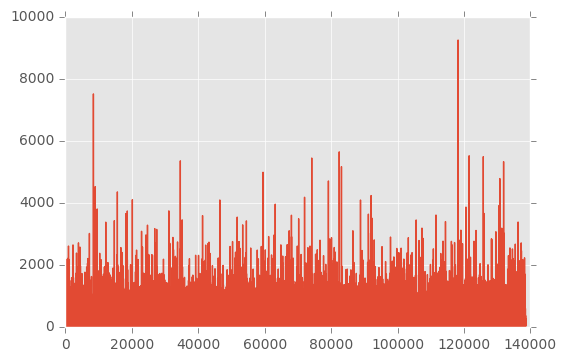

In [4]:
usersRatingCount = data.map(lambda rating: (rating['userId'],1)).countByKey().items()
plt.plot(*zip(*usersRatingCount));

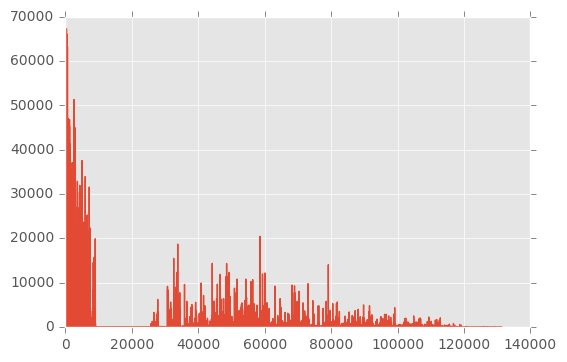

In [5]:
moviesRatingCount = sorted(data.map(lambda rating: (rating['movieId'],1)).countByKey().items())
plt.plot(*zip(*moviesRatingCount));

In [6]:
def isValidation(rating):
    if rating['timestamp']%10 in [1,2]:
        return True
    return False
def isTraining(rating):
    return not isValidation(rating)
training, validation = (data.filter(f) for f in(isTraining,isValidation))

In [7]:
trainingSize = training.count()
validationSize = validation.count()
print("Ratio of training is %2.f and validation is %2.f"%(trainingSize/numRatings*100,validationSize/numRatings*100))

Ratio of training is 80 and validation is 20


In [8]:
mu = training.map(lambda rating: rating['rating']).mean()

In [9]:
alpha = training.map(lambda rating: (rating['userId'],rating['rating']-mu)).groupByKey().mapValues(list).map(lambda rating: (rating[0],np.mean(rating[1]))).collectAsMap()

In [10]:
beta = training.map(lambda rating: (rating['movieId'],rating['rating']-alpha[rating['userId']]-mu)).groupByKey().mapValues(list).map(lambda rating: (rating[0],np.mean(rating[1]))).collectAsMap()

In [11]:
alphaMean = np.mean(list(alpha.values()))
betaMean = np.mean(list(beta.values()))
validationMap = validation.map(lambda rating: ((rating['userId'],rating['movieId']),rating['rating'])).collectAsMap()

In [12]:
estimatedMap = defaultdict(lambda: {})
for userId, movieId in validationMap.keys():
    estimatedMap[userId][movieId] = np.clip(mu+alpha.get(userId,alphaMean)+beta.get(movieId,betaMean),0.5,5.0)

In [13]:
numUsers = data.map(lambda rating: rating['userId']).distinct().count()    

In [14]:
def error(estimate):
    sumU = 0
    numUsers = 0
    for user in estimate.keys():
        sumM = 0
        numMovies = 0
        for movie, rating in estimate[user].items():
            sumM += (rating-validationMap[(user,movie)])**2
            numMovies += 1
        sumU += np.sqrt(1./numMovies*sumM)
        numUsers += 1
    return 1./numUsers*sumU
error(estimatedMap)

0.86693421039450369

# 3.2.2 Matrix-factorization model

In [15]:
model = rec.ALS.train(training.map(lambda rating: (rating['userId'],rating['movieId'],rating['rating'])),5,lambda_=0.0001)
prediction = model.predictAll(validation.map(lambda rating: (rating['userId'],rating['movieId'])))
estimation = prediction.collect()
estimatedMap2 = defaultdict(lambda: {})
for userId, movieId, rating in estimation:
    estimatedMap2[userId][movieId] =rating

In [130]:
error(estimatedMap2) # rank =25

1.1871482170678893

In [132]:
error(estimatedMap2) # rank = 12

0.9404401945716474

In [136]:
error(estimatedMap2) # rank =5, lambda = 10.0

3.7452269667338722

In [138]:
error(estimatedMap2) # rank =5, lambda = 0.5

1.0131218972771603

In [128]:
error(estimatedMap2) # rank =5, lambda = 0.0001

0.8524675667492102

In [140]:
error(estimatedMap2) # rank =5, lambda = 0.00001

0.88821879272498194

In [19]:
dataMovie = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
movie2name = dict(dataMovie.map(itemgetter("movieId", "title")).collect())

In [25]:
def recommendMovies(userId,number=10):
    movies = []
    for rating in model.recommendProducts(userId,number):
        movies.append(movie2name[rating[1]])
    return movies

In [30]:
print("Recommendations for user 123")
for movie in recommendMovies(123):
    print("-", movie)
print("\nRecommendations for us")
for movie in recommendMovies(138494):
    print("-",movie)

Recommendations for user 123
- Action Jackson (2014)
- Swan and the Wanderer, The (Kulkuri ja joutsen) (1999)
- The Kiss (1900)
- Dragon Gate Inn (Dragon Inn) (Long men kezhan) (1967)
- Sinbad (Szindbád) (1971)
- Black God, White Devil (Deus e o Diabo na Terra do Sol) (1964)
- Birth of the Living Dead (2013)
- It Is Written in the Stars, Inspector Palmu (Tähdet kertovat, komisario Palmu) (1962)
- Cobweb, The (1955)
- Purgatory (1999)

Recommendations for us
- Combat Shock (1986)
- Reminiscences of a Journey to Lithuania (1972)
- The Kiss (1900)
- Liverpool (2008)
- My Kingdom (2001)
- Maradona, the Hand of God (Maradona, la mano di Dio) (2007)
- Barren Lives (Vidas Secas) (1963)
- Thick-Walled Room, The (Kabe atsuki heya) (1953)
- On Top of the Whale (Het dak van de Walvis) (1982)
- Story of Marie and Julien, The (Histoire de Marie et Julien) (2003)


In [34]:
model2 = rec.ALS.train(training.map(lambda rating: (rating['userId'],rating['movieId'],rating['rating'])),2,lambda_=0.0001)

In [35]:
features = model2.productFeatures().collectAsMap()

In [43]:
# Reading an object from disk.
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")
    
data=dict(
            x=[],
            y=[],
            name=[],
            score=[],
            color=[],
        )

for movie in movies:
    coords = features[movie[0]]
    data['x'].append(coords[0])
    data['y'].append(coords[1])
    data['name'].append(movie[1])
    data['score'].append(movie[2])
    data['color'].append(rgb2hex(plt.get_cmap('RdYlGn')(movie[2])[:3]))
source = ColumnDataSource(data)
hover = HoverTool(
        tooltips=[
            ("name", "@name"),
            ("RT score","@score"),
        ]
    )

p = figure(plot_width=600, plot_height=600, tools=[hover],
           title="Movies")

p.circle('x', 'y', size=20, source=source, color='color')

show(p)